In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, PoissonRegressor, LinearRegression

import sys
sys.path.append('/home/rachel/Documents/lfp2spikes/modularized_code') 
from models.fit_model import MODEL_FITTING
from models.testing import EVALUATION

In [2]:
import pandas as pd
import numpy as np
from numpy.random import shuffle
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm


class EVALUATION(): 
    
    def __init__(self, model_mode): 
        self.mode = model_mode 
        
        
    def neg_log_lik(
        self, 
        theta, 
        X,
        y
    ):

        # Build the full design matrix
        if X.shape[-1] == theta.shape[-1]-1:    
            bias = np.ones(X.shape[0])
            X_dsgn = np.column_stack([bias, X])
        else: 
            X_dsgn = X
                    
        # Compute the Poisson log likelihood
        rate = np.exp(X_dsgn @ theta)
        return -(y @ np.log(rate) - rate.sum())  

        
    def validate_model(
        self, 
        X,
        y,
        theta
    ):
        if self.mode=="stats": # statsmodels
            return self.neg_log_lik(theta, X, y)       
                
        elif self.mode=="sklearn": # sklearn
            return self.neg_log_lik(theta, X, y) 
        
        
    def predict_spike_rate(
        self, 
        model, 
        theta,
        X
    ):
        if self.mode=="stats": # statsmodels
            X = sm.add_constant(X)
            return model.predict(params=theta, exog=X)      
                
        elif self.mode=="sklearn": # sklearn
            return model.predict(X)
        
        
    def evaluate_model(
        self, 
        model, 
        theta, 
        X,
        y
    ):
        nll = self.validate_model(X, y, theta)
        
        y_pred = self.predict_spike_rate(model, theta, X)
        mse = mean_squared_error(y, y_pred)
        
        return nll, mse
    
    
    def random_spike_compare(
        self, 
        cv_models, 
        cv_thetas, 
        cv_dataframes,
        n_rand
    ):
        evals_train = []
        evals_val = []
        evals_test = []
        
        for s in range(len(cv_dataframes)): 
            print(f"\n>>>>>>>>> Start Split {s+1}")
            [X_df, y_df] = cv_dataframes[s]
            models = cv_models[s]
            thetas = cv_thetas[s]
            
            evals_train_s = []
            evals_val_s = []
            evals_test_s = []
            
            # for all neurons
            for n in range(len(X_df)): 
                print(f"--- Unit {n} ---")
                evals_train_n = []
                evals_val_n = []
                evals_test_n = []
            
                model = models[n]
                theta = thetas[n]
                
                X_train = X_df.train_dt[n]
                y_train = y_df.train_dt[n]
                
                X_val = X_df.val_dt[n]
                y_val = y_df.val_dt[n]
                
                X_test = X_df.test_dt[n]
                y_test = y_df.test_dt[n]
                
                # Perform evaluation for original data
                evals_train_n.append(self.evaluate_model(model, theta, X_train, y_train))
                evals_val_n.append(self.evaluate_model(model, theta, X_val, y_val))
                evals_test_n.append(self.evaluate_model(model, theta, X_test, y_test))
                
                # Perform evaluation for n_rand random permutations of spikes
                for r in range(n_rand): 
                    # random permutation of spikes
                    shuffle(y_train)
                    shuffle(y_val)
                    shuffle(y_test)
                    
                    # evaluate
                    evals_train_n.append(self.evaluate_model(model, theta, X_train, y_train))
                    evals_val_n.append(self.evaluate_model(model, theta, X_val, y_val))
                    evals_test_n.append(self.evaluate_model(model, theta, X_test, y_test))
                    
                evals_train_s.append(evals_train_n)
                evals_val_s.append(evals_val_n)
                evals_test_s.append(evals_test_n)
                
            evals_train.append(evals_train_s)
            evals_val.append(evals_val_s)
            evals_test.append(evals_test_s)
            
            print(f"\n>>>>>>>>> End Split {s+1}")
            
        evals_train = np.array(evals_train)
        evals_val = np.array(evals_val)
        evals_test = np.array(evals_test)                       
                
        return evals_train, evals_val, evals_test
    
    
    def result_np2pd(
        self, 
        array
    ):    
        arr_shape = array.shape

        pd_ls = []
        for s in range(arr_shape[0]): 
            split_ls = []
            for u in range(arr_shape[1]): 
                u_pd = pd.DataFrame(array[s,u,:])
                u_pd.columns = ["Negative Log-Likelihood", "MSE"]
                u_pd["trial"] = np.arange(0,arr_shape[2],1)
                u_pd["unit"] = u
                u_pd["split"] = s
                #print(u_pd.head())

                split_ls.append(u_pd)

            pd_ls.append(
                pd.concat(split_ls)
            )
        
        return pd.concat(pd_ls)
            
        
                
                

In [3]:
model_mode = "stats"
fitter = MODEL_FITTING(model_mode)
evaluator = EVALUATION(model_mode)

In [5]:
buffer_size = 15
splits = [1,2,3,4,5]
bin_size = 1
c = (10, 1)
spike_type = "SUA"
spike_combo = "sumExt"
origin = 'zscored'

channels = "channels_5-40"

lfp_path = f'../data_prep/data/{spike_type}/{channels}/pat66_lfps{spike_type}_df_{origin}_c{c}_b{bin_size}'
spike_path = f'../data_prep/data/{spike_type}/{channels}/pat66_spikes{spike_type}_df_b{bin_size}_c{c}'

cv_df = fitter.load_split_data(
    splits, 
    lfp_path, 
    spike_path
)

In [ ]:
best_params = {"alpha": 0.01, "L1_wt" : 1.0}
models, thetas = fitter.cv_fit_per_neuron(cv_df, **best_params)


>>>>>>>>> Start Split 1
--- Unit 0 ---
--- Unit 1 ---
--- Unit 2 ---
--- Unit 3 ---
--- Unit 4 ---
--- Unit 5 ---
--- Unit 6 ---
--- Unit 7 ---
--- Unit 8 ---
--- Unit 9 ---
--- Unit 10 ---
--- Unit 11 ---
--- Unit 12 ---
--- Unit 13 ---
--- Unit 14 ---
--- Unit 15 ---
>>>>>>>>> End Split 1

>>>>>>>>> Start Split 2
--- Unit 0 ---
--- Unit 1 ---
--- Unit 2 ---
--- Unit 3 ---
--- Unit 4 ---
--- Unit 5 ---
--- Unit 6 ---
--- Unit 7 ---
--- Unit 8 ---
--- Unit 9 ---
--- Unit 10 ---
--- Unit 11 ---
--- Unit 12 ---
--- Unit 13 ---
--- Unit 14 ---
--- Unit 15 ---
>>>>>>>>> End Split 2

>>>>>>>>> Start Split 3
--- Unit 0 ---
--- Unit 1 ---
--- Unit 2 ---


In [38]:
X = cv_df[0][0].iloc[0]["val_dt"]
y = cv_df[0][1].iloc[0]["val_dt"]

In [36]:
import statsmodels.api as sm

X = sm.add_constant(X)
y_pred = models[0][0].predict(params=thetas[0][0], exog=X)

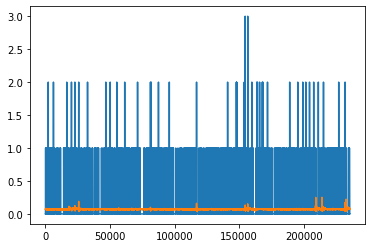

In [40]:
plt.plot(y)
plt.plot(y_pred)
plt.show()

In [9]:
import statsmodels.api as sm
num_rand_permuts = 10
evals_train, evals_val, evals_test = evaluator.random_spike_compare(
    models, 
    thetas, 
    cv_df, 
    num_rand_permuts
)


>>>>>>>>> Start Split 1
--- Unit 0 ---
--- Unit 1 ---
--- Unit 2 ---
--- Unit 3 ---
--- Unit 4 ---

>>>>>>>>> End Split 1

>>>>>>>>> Start Split 2
--- Unit 0 ---
--- Unit 1 ---
--- Unit 2 ---
--- Unit 3 ---
--- Unit 4 ---

>>>>>>>>> End Split 2

>>>>>>>>> Start Split 3
--- Unit 0 ---
--- Unit 1 ---
--- Unit 2 ---
--- Unit 3 ---
--- Unit 4 ---

>>>>>>>>> End Split 3

>>>>>>>>> Start Split 4
--- Unit 0 ---
--- Unit 1 ---
--- Unit 2 ---
--- Unit 3 ---
--- Unit 4 ---

>>>>>>>>> End Split 4

>>>>>>>>> Start Split 5
--- Unit 0 ---
--- Unit 1 ---
--- Unit 2 ---
--- Unit 3 ---
--- Unit 4 ---

>>>>>>>>> End Split 5


In [10]:
evals_train_df = evaluator.result_np2pd(evals_train)
evals_val_df = evaluator.result_np2pd(evals_val)
evals_test_df = evaluator.result_np2pd(evals_test)

In [11]:
evals_test_df.head()

,Negative Log-Likelihood,MSE,trial,unit,split
0,57156.828923,0.069065,0,0,0
1,57710.922206,0.069506,1,0,0
2,57693.585500,0.069498,2,0,0
3,57714.826924,0.069510,3,0,0
4,57723.121688,0.069519,4,0,0


<Figure size 774x270 with 0 Axes>

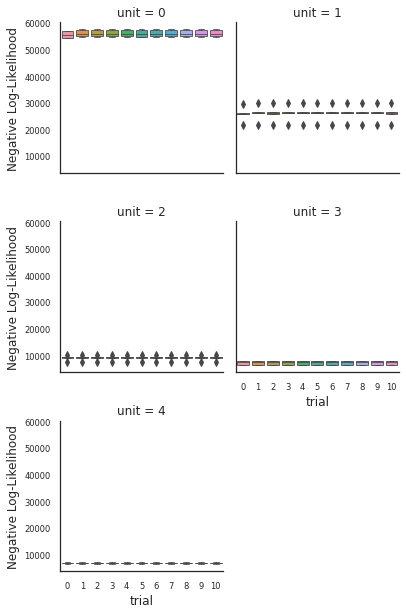

In [24]:
tic_font_size = "x-small"
label_font_size = "small"
import seaborn as sns
import matplotlib
rc = {
    "figure.figsize":(10.75, 3.75),
    "font.family":"sans serif", 
    "text.usetex":False,
    "xtick.labelsize":tic_font_size,
    "ytick.labelsize":tic_font_size,
    "axes.axisbelow":True,
    "lines.linewidth":0.8, 
    "legend.fancybox":True, 
    # "text.usetex" : True, 
    # "pdf.fonttype" : 42
}

matplotlib.rcParams["lines.linewidth"] = 0.8
matplotlib.rcParams["legend.fancybox"] = True
sns.set(rc=rc)
sns.set_style('white')

plt.tight_layout()


fig = sns.catplot(
    y="Negative Log-Likelihood", 
    x="trial", 
    col="unit", 
    kind="box", 
    data=evals_test_df, 
    height=2.9, 
    aspect=1, 
    col_wrap=2
)

fig.savefig('../evalutation/plots/plot_eval.png')
fig.savefig('../evalutation/plots/plot_eval.pdf')

In [ ]:
sns.lineplot(y="Negative Log-Likelihood", x="trial", , , data=eval_test_df)
plt.show()

3

In [7]:
a = np.array(evals_test).mean(axis=1)
a

array([[[2.12887773e+04, 2.37620089e-02],
        [2.20593889e+04, 2.46023764e-02],
        [2.20601578e+04, 2.46150149e-02],
        [2.20595360e+04, 2.46189074e-02],
        [2.20478459e+04, 2.46150089e-02],
        [2.20585548e+04, 2.46131718e-02],
        [2.20597675e+04, 2.46142575e-02],
        [2.20615686e+04, 2.46161615e-02],
        [2.20697352e+04, 2.46280123e-02],
        [2.20565556e+04, 2.46228466e-02],
        [2.20522700e+04, 2.46084796e-02]],

       [[1.88463232e+04, 1.99522130e-02],
        [1.92753192e+04, 2.02494636e-02],
        [1.92822644e+04, 2.02603454e-02],
        [1.92895677e+04, 2.02600943e-02],
        [1.92882959e+04, 2.02591251e-02],
        [1.92879854e+04, 2.02603523e-02],
        [1.92815821e+04, 2.02567289e-02],
        [1.92907184e+04, 2.02599269e-02],
        [1.92780269e+04, 2.02570985e-02],
        [1.92803192e+04, 2.02573209e-02],
        [1.92819712e+04, 2.02594133e-02]],

       [[1.97368400e+04, 1.99634917e-02],
        [2.03869338e+04, 2.071

In [33]:
a[:, :, 0]

array([[21288.77730176, 22065.87648105, 22058.46336621, 22076.77645741,
        22056.36032898, 22078.72308768, 22049.02062166, 22073.39821849,
        22045.98760448, 22046.82043844, 22066.13826433],
       [18846.32318745, 19280.06229783, 19285.11184816, 19276.37168409,
        19279.15716312, 19276.89363021, 19282.4876403 , 19289.52137063,
        19275.73723511, 19292.48994915, 19278.16424763],
       [19736.83996362, 20364.93697512, 20376.67095828, 20374.44231336,
        20369.27513536, 20384.05404212, 20373.77304915, 20366.28418138,
        20383.55843562, 20382.06879516, 20387.05933697],
       [19161.63408712, 19494.83117289, 19500.51942344, 19491.68392865,
        19509.55530293, 19494.89252892, 19494.45756798, 19506.85244668,
        19500.24759358, 19481.8085313 , 19506.02026206],
       [19942.03792361, 20430.62301684, 20418.70505275, 20434.49930895,
        20436.52289673, 20422.40424191, 20415.38908594, 20440.60878224,
        20422.04303049, 20432.13672994, 20426.228836

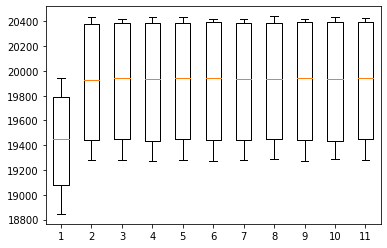

In [49]:
plt.boxplot(a[1:, :, 0])
plt.show()